# Exploratory Data Analysis (EDA)
**Input**: Clean data stored in PostgreSQL

**Output**: At the end of this phase we will have explored the data and have the knowledge for selecting useful features in the next step.

First thing, we are going to answer the following questions:
1. How is data distributed?
2. How should we manage outliers? 
3. Should we transform data?
4. How are features correlated?

## How is data distributed?
We retrieve data from PostgreSQL created in the "Data Cleaning" step and pivot it to make it easy to analyse and plot.

To do this we use a helper function that simply requests data from DB with a filter on dates between 1960-01-01 and 2022-12-31.

In [1]:
# move to root to simplify imports
%cd ..

C:\Users\marco\PycharmProjects\portfolio-optimization


In [2]:
from configparser import ConfigParser
import psycopg2

parser = ConfigParser()
_ = parser.read("credentials.cfg")
DB_USER = parser.get("postgresql", "DB_USER")
DB_PASS = parser.get("postgresql", "DB_PASS")
DB_HOST = parser.get("postgresql", "DB_HOST")
DB_NAME = parser.get("postgresql", "DB_NAME")
DB_PORT = parser.get("postgresql", "DB_PORT")

def get_connection():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connection parameters
        params = {
            'database': DB_NAME,
            'user': DB_USER,
            'password': DB_PASS,
            'host': DB_HOST
        }

        # connect to the PostgreSQL server
        conn = psycopg2.connect(**params)
        return conn
    except (Exception, psycopg2.DatabaseError) as error:
        print("CONNECTION ERROR: ", error)
        if conn is not None:
            conn.close()
            
def get_df_from_table(tablename, where=";"):
    """ Read table from DB and convert it to pandas DataFrame """
    conn = get_connection()
    cur = conn.cursor()
    q = f'''SELECT * FROM {tablename} {where}'''
    cur.execute(q)
    data = cur.fetchall()
    cols = []
    for elt in cur.description:
        cols.append(elt[0])
    df = pd.DataFrame(data=data, columns=cols)
    cur.close()
    return df

We load the table "indicator" containing cleaned data and the table "indicator_name" containing reference to features and target names.

This allows us to create aliases for titles and legends in charts.

In [3]:
from datetime import date
import pandas as pd

def get_df():
    # We get dataFrame from table "indicator"
    df = get_df_from_table("indicator", f"where date between '{date(1960, 1, 1)}' and '{date(2022, 12, 31)}'")
    df = df.drop("id", axis=1)

    # We get dataFrame from table "indicator_name", 
    # we do this to get labels for features and target
    name_df = get_df_from_table("indicator_name")
    df = pd.merge(df, name_df, left_on=["name"], right_on=["indicator"], how="inner")
    df = df.drop("indicator", axis=1)
    name_df = name_df.set_index("id")

    # We select which indicators are features and which are targets
    df["target_feature"] = "feature"
    df.loc[df["source"].isin(["yahoo_finance", "investing"]), "target_feature"] = "target"
    df.loc[df["name"].isin(['USSTHPI',
                            'Short-term interest rates | Total | % per annum',
                            'Long-term interest rates | Total | % per annum',
                            'Housing prices | Nominal house prices | 2015=100']), "target_feature"] = "target"
    df["column_name"] = df["target_feature"] + df["id"].astype(str)

    # Converting dataFrame values to datetime and numeric
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"])

    # Pivot df in order to have features and targets as columns and rows as dates.
    df = df.pivot_table(index="date", columns="column_name", values="value", aggfunc="sum").reset_index()
    df = df.set_index("date")
    return df, name_df

df, name_df = get_df()
df

column_name,feature1,feature10,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,...,target262,target263,target264,target265,target266,target267,target268,target55,target71,target82
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,NaN,100.78720,763.258,NaN,40.6,39.6291,52.208,1460.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0472,NaN,NaN
1960-02-01,NaN,100.03520,763.258,NaN,39.2,39.7872,52.208,1503.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0449,NaN,NaN
1960-03-01,NaN,99.05860,763.258,NaN,35.0,40.0180,52.208,1109.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0425,NaN,NaN
1960-04-01,NaN,98.29333,776.204,NaN,31.4,40.5152,52.295,1289.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0428,NaN,NaN
1960-05-01,NaN,97.88153,776.204,NaN,38.9,40.8926,52.295,1271.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0435,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,NaN,99.73845,NaN,14.14119,606.4,2721.9167,113.832,1508.0,0.0550,NaN,...,55.250000,11816.200195,89.550003,831.50,1710.96,181.165396,89.83,0.0290,0.0276,628.55
2022-09-01,NaN,99.51685,NaN,16.86149,574.4,2747.8114,113.832,1465.0,0.0573,NaN,...,51.349998,10575.620117,79.489998,921.50,1659.67,181.165396,80.03,0.0352,0.0321,628.55
2022-10-01,NaN,99.32253,NaN,20.86594,645.8,2779.6053,113.963,1426.0,0.0625,NaN,...,53.279999,10988.150391,86.529999,882.25,1633.12,181.772737,86.88,0.0398,0.0385,623.66


We now have a dataframe with 217 columns representing all features and targets.

To answer the question **How is data distributed?** we are going to plot data in three different ways:
- A line chart showing actual data across time
- A histogram showing data distribution
- A box and whisker chart showing the same data distribution with outliers

count    613.000000
mean       0.047019
std        0.028127
min       -0.026526
25%        0.029295
50%        0.041645
75%        0.068503
max        0.109866
Name: feature1, dtype: float64


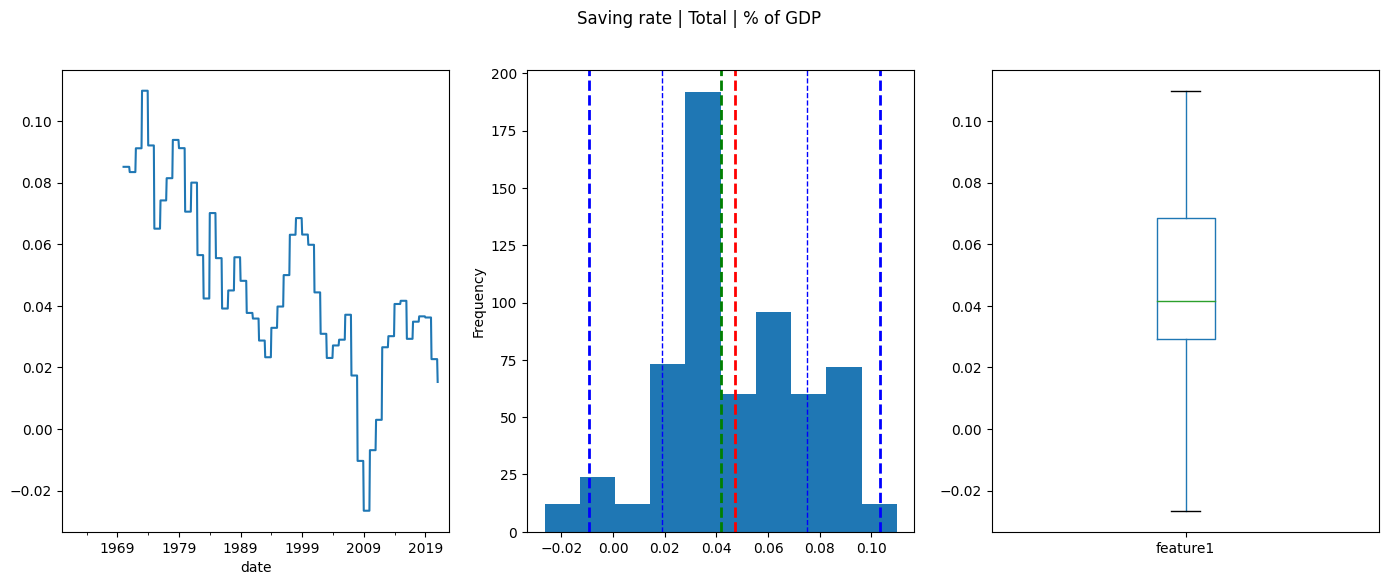

In [4]:
# Import plot library
import matplotlib.pyplot as plt

def plot_column(col):

    # retrieve title from column name
    id = int(col.replace('target', '').replace('feature', ''))
    title = name_df.loc[id, "indicator"]

    # get series description (count, mean, std and quartiles)
    d = df[col].describe()

    # To plot everything together we use a figure with 3 columns and 1 row.
    fig = plt.figure(figsize=(17,6))
    fig.suptitle(title)

    # In the first (left) chart we plot the raw data, and how is distributed in time.
    line = fig.add_subplot(131)
    line = df[col].plot(kind='line', grid=False)

    # In the second (center) chart we want to see an histogram representing the distribution of values.
    # to better identify key values we draw key lines on this chart.
    hist = fig.add_subplot(132)
    hist = df[col].plot(kind='hist', grid=False)
    hist.axvline(x=d['mean'], color='r', linestyle='--', lw=2 )
    hist.axvline(x=d['50%'], color='g', linestyle='--', lw=2 )
    hist.axvline(x=d['mean']-d['std'], color='b', linestyle='--', lw=1 )
    hist.axvline(x=d['mean']+d['std'], color='b', linestyle='--', lw=1 )
    hist.axvline(x=d['mean']-2*d['std'], color='b', linestyle='--', lw=2 )
    hist.axvline(x=d['mean']+2*d['std'], color='b', linestyle='--', lw=2 )

    # Then in the third (right) chart we want to see a box and whisker that help use identify outliers.
    box = fig.add_subplot(133)
    box = df[col].plot(kind='box', grid=False)
    print(d)

# selecting column 0 as an example, we will plot every column to see how data is distributed.
plot_column(df.columns[0])
plt.show()

## How should we manage outliers?
To loop through columns faster, we decided to only plot those whose data have a certain % of outliers.

We define an outlier with the following conditions:
- values that are lower than first quartile minus the interquartile range multiplied by 1.5
- values that are greater than third quartile plus the interquartile range multiplied by 1.5

In [5]:
def count_outliers(col):
    d = df[col].describe()
    interquartile_range = (d['75%'] - d['25%'])
    min_threshold = d['25%'] - interquartile_range * 1.5
    max_threshold = d['75%'] + interquartile_range * 1.5

    negative_outliers_count = df[df[col] < min_threshold][col].count()
    negative_percentage = round(negative_outliers_count/d['count']*100,2)
    
    positive_outliers_count = df[df[col] > max_threshold][col].count()
    positive_percentage = round(positive_outliers_count/d['count']*100,2)
    
    print(f"NEGATIVE OUTLIERS: {negative_outliers_count} ({negative_percentage}%)")
    print(f"POSITIVE OUTLIERS: {positive_outliers_count} ({positive_percentage}%)")
    
count_outliers(df.columns[1])

NEGATIVE OUTLIERS: 26 (3.44%)
POSITIVE OUTLIERS: 5 (0.66%)


We analized all series with at least 5% of "positive" or "negative" outliers and took the following considerations:
- To remove TOTBORR (feature92) *Total Borrowings of Depository Institutions from the Federal Reserve* because it is almost always 0 except for 2 time periods. https://fred.stlouisfed.org/series/TOTBORR
- To remove BORROW (feature165) *Total Borrowings from the Federal Reserve*, for the same reason. https://fred.stlouisfed.org/series/BORROW
- To remove NONBORRES (feature169) *Reserves of Depository Institutions, Nonborrowed*. Values are 0 until 2008. https://fred.stlouisfed.org/series/NONBORRES
- To remove TOTRESNS (feature199) *Reserves of Depository Institutions: Total*, for the same reason. https://fred.stlouisfed.org/series/TOTRESNS
- To remove TREASURY (feature78) *Treasury Deposits with Federal Reserve Banks*, for the same reason. https://fred.stlouisfed.org/series/TREASURY
- To remove series with missing data before 1995, like USCI (feature262) and other series
- To remove series with no data, like M0263AUSM500NNBR (feature85) *Existing Home Mortgage Applications for United States*, https://fred.stlouisfed.org/series/M0263AUSM500NNBR and other series.

Below some examples with charts of the mentioned series.

count    468.000000
mean       6.302821
std       30.826047
min        0.000000
25%        0.075938
50%        0.206300
75%        0.687662
max      406.574400
Name: feature92, dtype: float64
NEGATIVE OUTLIERS: 0 (0.0%)
POSITIVE OUTLIERS: 67 (14.32%)


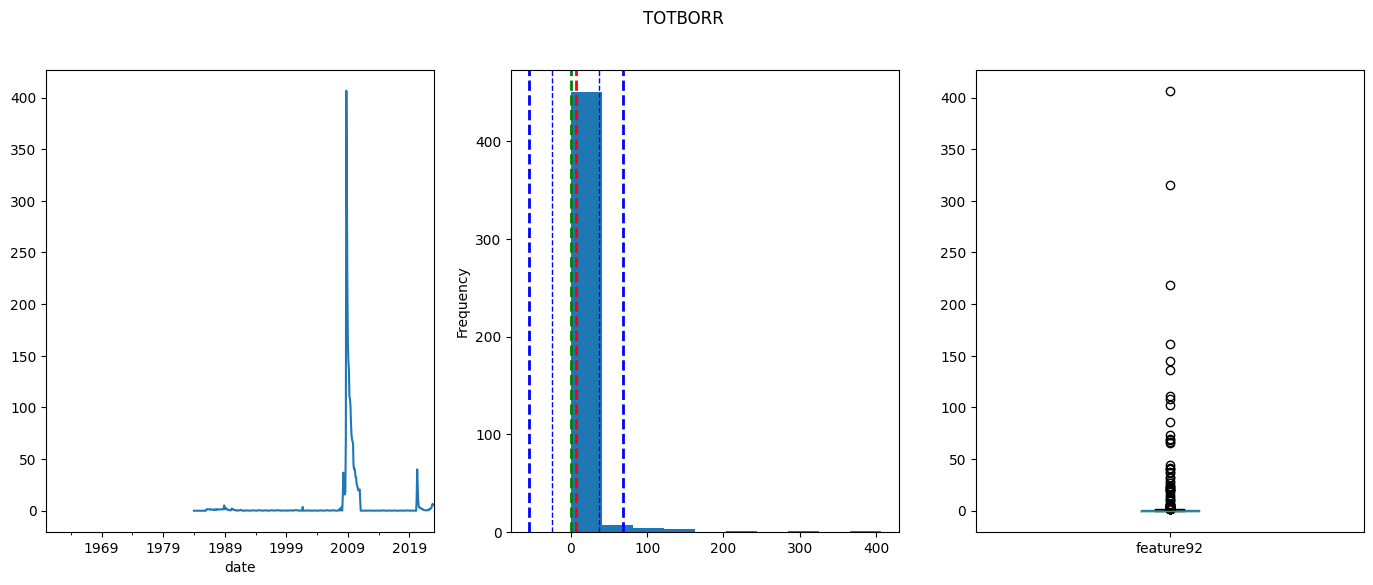

In [6]:
f = 'feature92'
plot_column(f)
count_outliers(f)
plt.show()

count    7.560000e+02
mean     5.082975e+05
std      9.761505e+05
min     -3.335000e+05
25%      3.377500e+04
50%      4.305000e+04
75%      6.012500e+04
max      4.149900e+06
Name: feature169, dtype: float64
NEGATIVE OUTLIERS: 10 (1.32%)
POSITIVE OUTLIERS: 169 (22.35%)


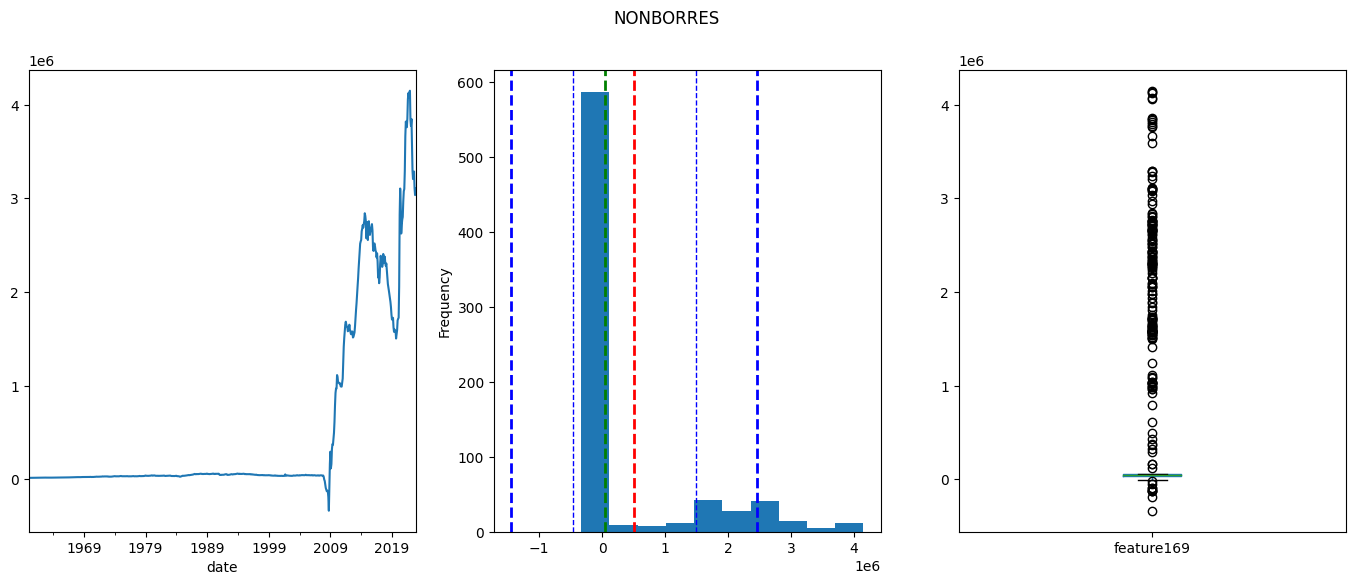

In [7]:
f = 'feature169'
plot_column(f)
count_outliers(f)
plt.show()

## Should we transform data?

Looping through all series we also identified some that need specific transformation:
- Business confidence index (feature10), Consumer confidence index (feature13) from OECD need to be normalized/standardized.
- JHGDPBRINDX (feature107) *GDP-Based Recession Indicator Index* needs to be normalized/standardized too. https://fred.stlouisfed.org/series/JHGDPBRINDX
- Normalize/standardized series with "spiky" series, like MTSDS133FMS (feature121) *Federal Surplus or Deficit*. https://fred.stlouisfed.org/series/MTSDS133FMS, and other series.

In general it seems that features needs to be normalized/standardized as they have very different value ranges, we will approach this in the next step "Feature Selection".

count    756.000000
mean      99.978160
std        1.399287
min       95.123920
25%       99.230210
50%      100.113650
75%      100.891575
max      103.999400
Name: feature10, dtype: float64
NEGATIVE OUTLIERS: 26 (3.44%)
POSITIVE OUTLIERS: 5 (0.66%)


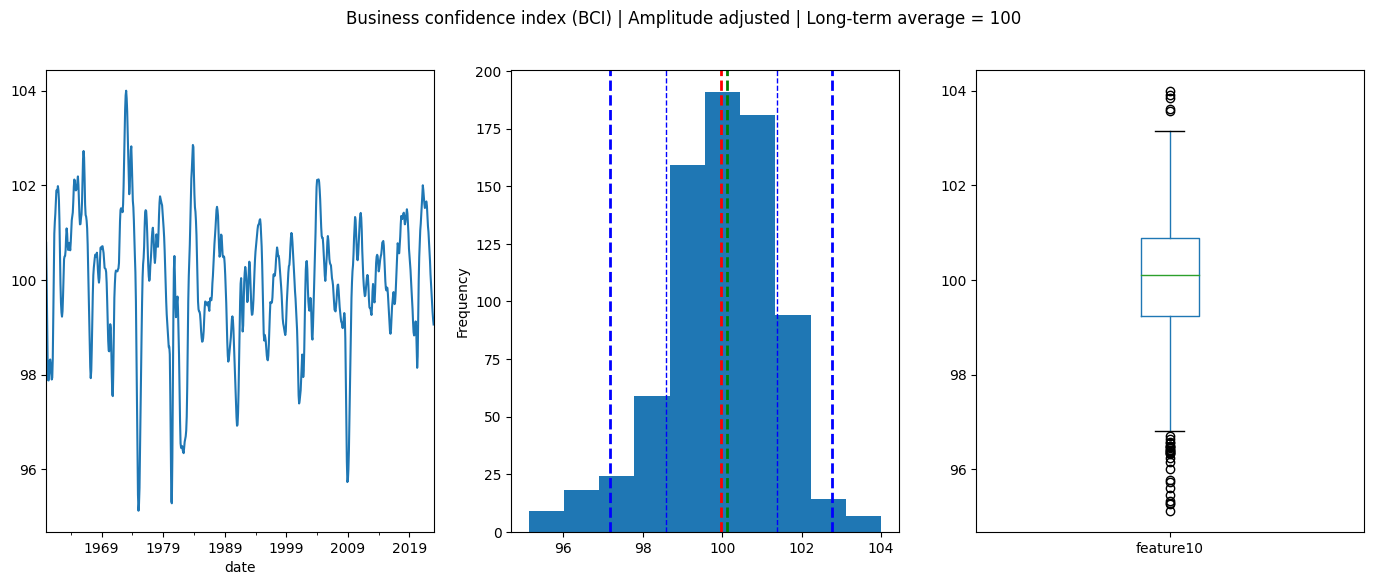

In [8]:
f = 'feature10'
plot_column(f)
count_outliers(f)
plt.show()

count       507.000000
mean     -43283.712976
std       99037.472450
min     -864074.068492
25%      -69352.500000
50%      -27919.000000
75%        3143.500000
max      308215.060527
Name: feature121, dtype: float64
NEGATIVE OUTLIERS: 40 (7.89%)
POSITIVE OUTLIERS: 17 (3.35%)


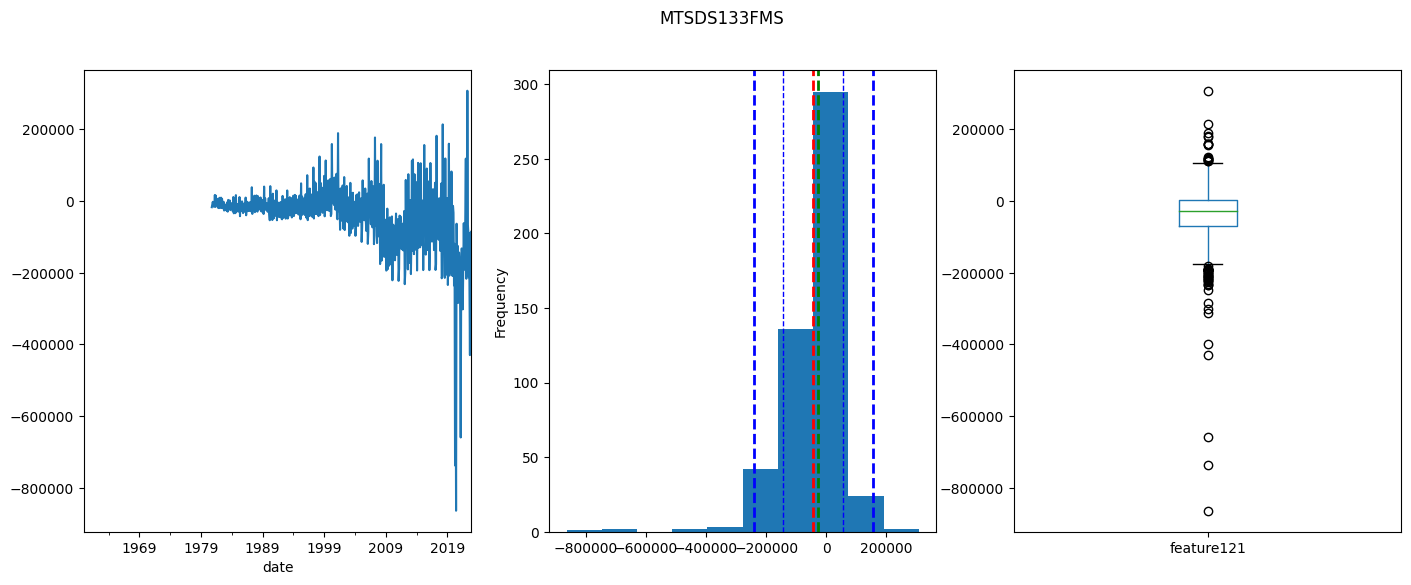

In [9]:
f = 'feature121'
plot_column(f)
count_outliers(f)
plt.show()

## How are features correlated?
Correlated feature aren't very useful since they give the same information and slow down the training process.

Hence we decided to identify correlated series and mark which one to remove. In general we keep the ones that are higher correlated with targets (and have more data).

We loop through all features, calculate the correlation, then if the correlation is greater than a certain threshold we decide which one to remove by counting the number of datapoints and evaluating the correlation with all the targets.

In [10]:
# First we update the get_df method to remove the outliers

def get_df(remove_outliers=True):
    # We get dataFrame from table "indicator"
    df = get_df_from_table("indicator", f"where date between '{date(1960, 1, 1)}' and '{date(2022, 12, 31)}'")
    df = df.drop("id", axis=1)

    # We get dataFrame from table "indicator_name", we do this to get labels for features and target
    name_df = get_df_from_table("indicator_name")
    df = pd.merge(df, name_df, left_on=["name"], right_on=["indicator"], how="inner")
    df = df.drop("indicator", axis=1)
    name_df = name_df.set_index("id")

    # This new code remove the series with outliers we identified previously 
    if remove_outliers:
        df = df[~df["name"].isin(['TOTBORR', 'BORROW ', 'TOTRESNS', 'NONBORRES ', '^DJUSRE', '^DJCI', 'USCI',
                              'CL=F', 'GC=F', '^SP500BDT', 'TREASURY', 'DDDM03USA156NWDB', 'M0263AUSM500NNBR',
                              'M14062USM027NNBR', 'M0264AUSM500NNBR', 'M1490AUSM157SNBR',
                              'Quarterly GDP | Total | Percentage change', 'Quarterly GDP | Total | Percentage change',
                              'Q09084USQ507NNBR',
                              'M0263AUSM500NNBR', 'M0264AUSM500NNBR', 'M1490AUSM157SNBR', 'M14062USM027NNBR',
                              'M09075USM476NNBR', 'Q09084USQ507NNBR',
                              'M09086USM156NNBR', 'DDDM03USA156NWDB', 'DDDM01USA156NWDB', 'DDEM01USA156NWDB',
                              'LABSHPUSA156NRUG', 'RTFPNAUSA632NRUG',
                              'SIPOVGINIUSA', 'DDDI06USA156NWDB', 'ITNETUSERP2USA',
                              'Electricity generation | Total | Gigawatt-hours'])]
        
    # We select which indicators are features and which are targets
    df["target_feature"] = "feature"
    df.loc[df["source"].isin(["yahoo_finance", "investing"]), "target_feature"] = "target"
    df.loc[df["name"].isin(['USSTHPI',
                            'Short-term interest rates | Total | % per annum',
                            'Long-term interest rates | Total | % per annum',
                            'Housing prices | Nominal house prices | 2015=100']), "target_feature"] = "target"
    df["column_name"] = df["target_feature"] + df["id"].astype(str)

    # Convert dataFrame values to datetime and numeric
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"])

    # Pivot df in order to have features and targets as columns and rows as dates.
    df = df.pivot_table(index="date", columns="column_name", values="value", aggfunc="sum").reset_index()
    df = df.set_index("date")
    return df, name_df

df, name_df = get_df()
df

column_name,feature1,feature10,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,...,target259,target260,target263,target265,target266,target267,target268,target55,target71,target82
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,NaN,100.78720,763.258,NaN,40.6,39.6291,52.208,1460.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0472,NaN,NaN
1960-02-01,NaN,100.03520,763.258,NaN,39.2,39.7872,52.208,1503.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0449,NaN,NaN
1960-03-01,NaN,99.05860,763.258,NaN,35.0,40.0180,52.208,1109.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0425,NaN,NaN
1960-04-01,NaN,98.29333,776.204,NaN,31.4,40.5152,52.295,1289.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0428,NaN,NaN
1960-05-01,NaN,97.88153,776.204,NaN,38.9,40.8926,52.295,1271.0,0.0500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0435,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,NaN,99.73845,NaN,14.14119,606.4,2721.9167,113.832,1508.0,0.0550,NaN,...,3955.000000,31510.429688,11816.200195,831.50,1710.96,181.165396,89.83,0.0290,0.0276,628.55
2022-09-01,NaN,99.51685,NaN,16.86149,574.4,2747.8114,113.832,1465.0,0.0573,NaN,...,3585.620117,28725.509766,10575.620117,921.50,1659.67,181.165396,80.03,0.0352,0.0321,628.55
2022-10-01,NaN,99.32253,NaN,20.86594,645.8,2779.6053,113.963,1426.0,0.0625,NaN,...,3871.979980,32732.949219,10988.150391,882.25,1633.12,181.772737,86.88,0.0398,0.0385,623.66


### Stationarity

Time series forecasting requires extra preprocessing steps, unlike ordinary machine learning problems.

Most ML algorithms expect a static relationship between the input features and the output, a static relationship requires inputs and outputs with constant parameters such as mean, median, and variance. In other words, algorithms perform best when the inputs and outputs are stationary.

Time series are non-stationary data. Meaning, distributions change over time and can have properties such as seasonality and trend. These, cause the mean and variance of the series to change over time, making it hard to model their behaviour.

First we are going to test non-stationarity of our series. We can do this with some tests. The one we have chosen is *Augmented Dickey-Fuller unit root test*.

**Null hypothesis**: the series is non-stationary, time-dependent (it has a unit root).

**Alternative hypothesis**: the series is already stationary, not time-dependent (can't be represented by a unit root)

The ADFuller test will return a p-value for the time series. If it is smaller than a critical threshold of 0.05 or 0.01, we reject the null hypothesis and conclude that the series is stationary. Otherwise, we fail to reject the null hypothesis and conclude the series is non-stationary.

Adfuller p-value: 1.0


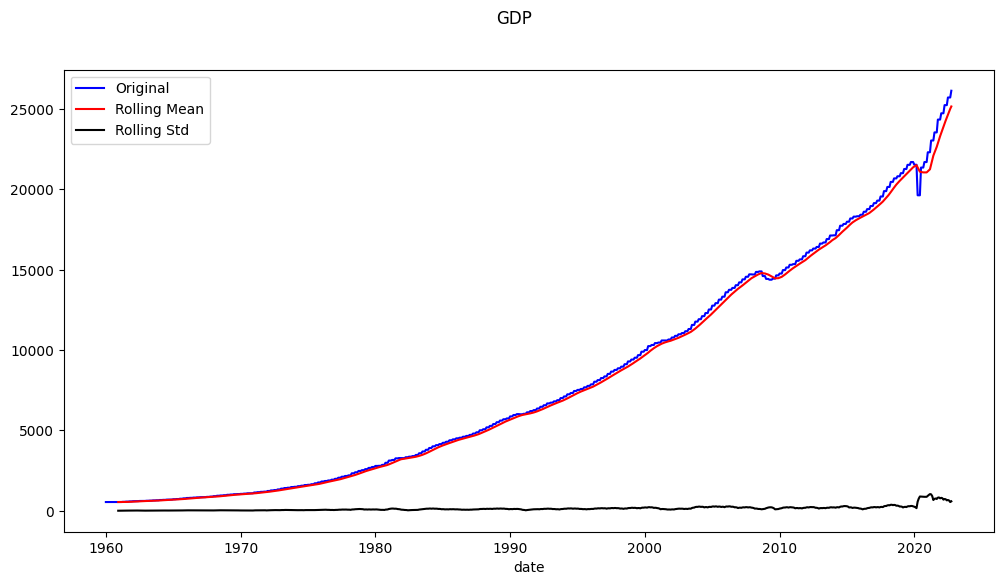

In [11]:
from statsmodels.tsa.stattools import adfuller

def get_stationarity(df, col):
    col_df = df[col].dropna()
    id = int(col.replace('target', '').replace('feature', ''))
    title = name_df.loc[id, "indicator"]
    
    # rolling statistics
    # if rolling mean and/or std move over time (line is not horizontal) data is non-stationary. 
    # non-stationary = value does depend on date
    rolling_mean = col_df.rolling(window=12).mean()
    rolling_std = col_df.rolling(window=12).std()

    # Dickey–Fuller test
    # if p-value is > 0.05 we can conclude data is non-stationary.
    # non-stationary = value does depend on date
    result = adfuller(col_df)
    print('Adfuller p-value: {}'.format(result[1]))

    # rolling statistics plot
    fig = plt.figure(figsize=(12,6))
    fig.suptitle(title)
    original = plt.plot(col_df, color='blue', label='Original')
    plt.xlabel('date')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')

# We use as example feature77 that represents GDP
col = 'feature77'
get_stationarity(df, col)
plt.show()

We can see that p-value is 1, hence this series is surely time-dependent.

To make it stationary we are going to use a simple method. 

Differencing data of a time series we can reach stationarity. Meaning we subtract for each data point the previous value. Doing so we will have for each date the difference from the previous date instead of the actual value.

Pandas dataframe has a function to do exactly that.

In [12]:
stationary_df = df.diff(periods=1)
stationary_df

column_name,feature1,feature10,feature100,feature101,feature102,feature103,feature104,feature105,feature106,feature107,...,target259,target260,target263,target265,target266,target267,target268,target55,target71,target82
date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,NaN,-0.75200,0.000,NaN,-1.4,0.1581,0.000,43.0,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0023,NaN,NaN
1960-03-01,NaN,-0.97660,0.000,NaN,-4.2,0.2308,0.000,-394.0,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0024,NaN,NaN
1960-04-01,NaN,-0.76527,12.946,NaN,-3.6,0.4972,0.087,180.0,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0003,NaN,NaN
1960-05-01,NaN,-0.41180,0.000,NaN,7.5,0.3774,0.000,-18.0,0.0000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0007,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,NaN,-0.17593,NaN,-10.39436,-38.3,26.9643,0.000,131.0,0.0065,NaN,...,-175.290039,-1334.699219,-574.490234,23.75,-55.26,-0.350545,-9.78,0.0000,0.0026,-0.33
2022-09-01,NaN,-0.22160,NaN,2.72030,-32.0,25.8947,0.000,-43.0,0.0023,NaN,...,-369.379883,-2784.919922,-1240.580078,90.00,-51.29,0.000000,-9.80,0.0062,0.0045,0.00
2022-10-01,NaN,-0.19432,NaN,4.00445,71.4,31.7939,0.131,-39.0,0.0052,NaN,...,286.359863,4007.439453,412.530273,-39.25,-26.55,0.607342,6.85,0.0046,0.0064,-4.89


Adfuller p-value: 0.0012384488540951293


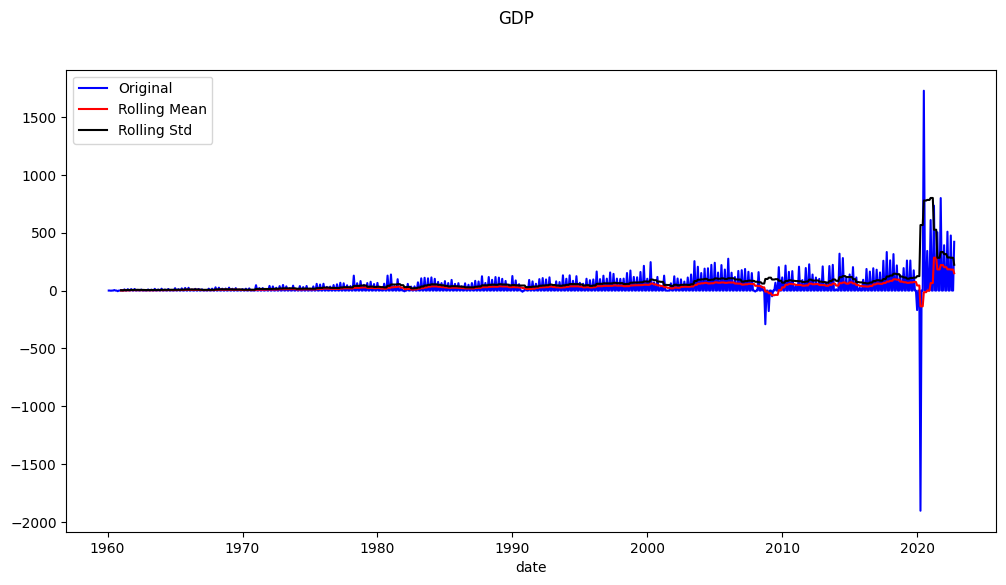

In [13]:
# Again we use as example feature77 that represents GDP, to see if differencing reduced p-value and gave us a stationary series
col = 'feature77'
get_stationarity(stationary_df, col)
plt.show()

As we can see from the p-value, differencing data with the previous period give us a stationary series.

With this new dataframe we are going look for correlation among features.

This step is important since we want features that are truly correlated between them. Otherwise, we could get high correlation because both features are highly correlated with a 3rd variable (time). Removing the time variable was necessary to avoid this situation.

Below an example of how we calculate the correlation between GDP (feature77) and Saving rate (feature1). 
To see how results change first we are going to check correlation before and after the stationarity trasformation.

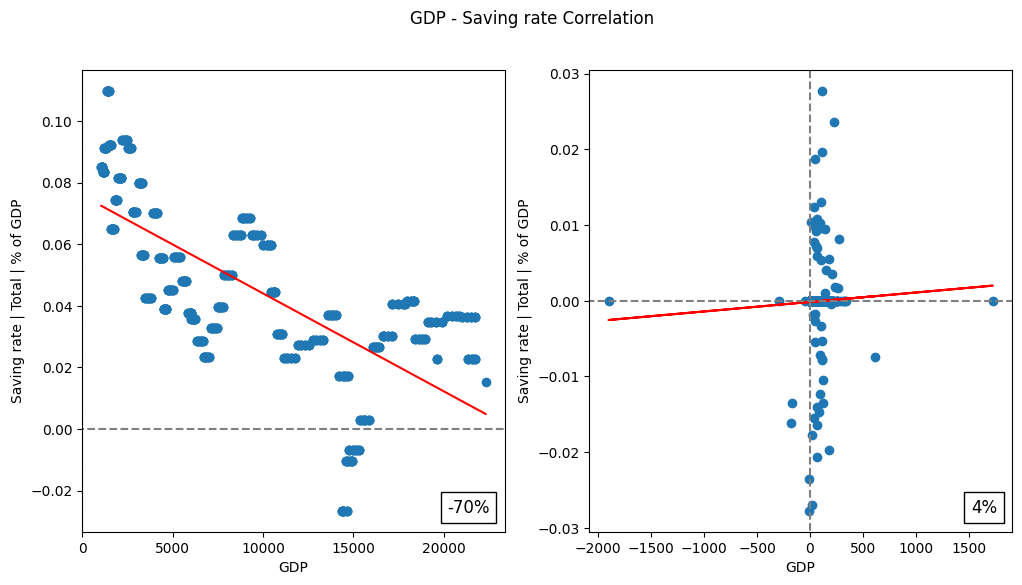

In [14]:
from sklearn.linear_model import LinearRegression
from matplotlib.offsetbox import AnchoredText

def get_correlation(df, col1, col2, ax):

    title1 = name_df.loc[int(col1.replace('target', '').replace('feature', '')), "indicator"]
    title2 = name_df.loc[int(col2.replace('target', '').replace('feature', '')), "indicator"]

    col_df = df[[col1, col2]].dropna()
    
    # To evaluate correlation between the two features
    corr = col_df[col1].corr(col_df[col2])

    # Get line of best fit
    linear = LinearRegression()
    linear.fit(col_df[[col1]],col_df[[col2]])
    
    ax.scatter(col_df[col1], col_df[col2])
    ax.plot(col_df[col1], linear.predict(col_df[[col1]]), color="red")
    ax.axvline(x=0, ymin=-1, ymax=1, linestyle="dashed", color="gray")
    ax.axhline(y=0, xmin=-1, xmax=1, linestyle="dashed", color="gray")
    ax.set_xlabel(title1)
    ax.set_ylabel(title2)
    at = AnchoredText(
            f"{corr:.0%}",
            prop=dict(size="large"),
            frameon=True,
            loc="lower right",
        )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)

col1 = 'feature77' # GDP
col2 = 'feature1' # Saving rate
fig = plt.figure(figsize=(12,6))
fig.suptitle("GDP - Saving rate Correlation")
ax1 = fig.add_subplot(121)
get_correlation(df, col1, col2, ax1)
ax2 = fig.add_subplot(122)
get_correlation(stationary_df, col1, col2, ax2)
plt.show()

On the left chart, features are highly correlated (-70%). But this is due to the fact that both are correlated with time.

On the right chart, we removed the time dependency and we can see that they are not correlated at all (4%).


To idenfity all possible correlated feature pairs we looped through all features in the dataframe. 

Then, when a pair with high correlation is found (we used 80% as threshold with satisfying results), we evaluate the number of data points and the correlation with the target seriess.

Features correlation are saved in MongoDB within a new document called *feature_correlation_0.8* in the *feature_selection* collection.

This document contains one element for each pair with correlation higher than 80%, containing the number of data points for each of 2 features and the absolute mean correlation with the targets for each of the 2 features. To calculate the absolute mean correlation with the target we took the correlation of that feature with each target, and calculate the mean of the absolute values (we are interest in the magnitude of the correlation, not the sign).

We have a total of 139 feature pairs.

In [15]:
feature_correlation = {
  "_id": "feature_correlation_0.8",
  "data": [
    {
      "col_1": "feature100",
      "col_2": "feature143",
      "corr": 0.9208957065068195,
      "c_1": 750,
      "c_2": 750,
      "corr_1": 0.11212307319417723,
      "corr_2": 0.11630831606931778
    },
    {
      "col_1": "feature102",
      "col_2": "feature118",
      "corr": 0.9258819460661312,
      "c_1": 755,
      "c_2": 755,
      "corr_1": 0.07906746378736886,
      "corr_2": 0.07908686817741475
    },
      ...
  ]
}

Now we are ready to go into the next step "Feature Selection", where we will use this to help us select the best features for our model.

[Go to Feature Selection](feature_selection.ipynb)